**IMPORT REQUIRED LIBRARIES**

In [0]:
import pandas as pd 
from keras.models import Sequential,Model
from keras.layers import Embedding, SimpleRNN,Input
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout
from keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools    
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from collections import Counter


Using TensorFlow backend.


**DATA PREPROCESSING**

In [0]:
data = pd.read_json("earnings_call_ip_data.json",orient='columns')
data_inputs =  data["text"].get_values()
# Convert sentiments into 0,1,2
sent = {'positive': 1,'negative': 0,'neutral': 2} 
data.sentiment = [sent[item] for item in data.sentiment] 

In [0]:
data_labels = data.sentiment

**TOKENIZING WORDS **

In [0]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 6395 unique tokens.
Shape of data tensor: (1649, 1000)
Shape of label tensor: (1649, 3)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

**CREATING EMBEDDING MATRIX WITH HELP OF PRETRAINED MODEL**

Model used: Glove


In [0]:
embeddings_index = {}
f = open( 'glove_pre.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 12230 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


**MODEL CREATION**

In [0]:

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)


In [0]:
def model_creation():
  input_layer = Input(shape=(1000,), dtype='int32')
  embed_layer = embedding_layer(input_layer)
  x = Dense(100,activation='relu')(embed_layer)
  x = Dense(50,activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
  x = Flatten()(x)
  x = Dense(50,activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
  x = Dropout(0.5)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.5)(x)
  #x = Dense(512, activation='relu')(x)
  #x = Dropout(0.4)(x)
  final_layer = Dense(3, activation='softmax')(x)
  opt = keras.optimizers.Adam(lr= learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model = Model(input_layer,final_layer)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
  return model 

In [0]:
learning_rate = 0.0001
batch_size = 1024
epochs = 200
model_glove = model_creation()
model_final = model_glove.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size)

Train on 1320 samples, validate on 329 samples
Epoch 1/200
1320/1320 [==============================] - 8s 6ms/step - loss: 1.4763 - acc: 0.3076 - val_loss: 1.4042 - val_acc: 0.5410
Epoch 2/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.4176 - acc: 0.3985 - val_loss: 1.3704 - val_acc: 0.6322
Epoch 3/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.3820 - acc: 0.4667 - val_loss: 1.3448 - val_acc: 0.6383
Epoch 4/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.3755 - acc: 0.4841 - val_loss: 1.3213 - val_acc: 0.6383
Epoch 5/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.3692 - acc: 0.4848 - val_loss: 1.3017 - val_acc: 0.6292
Epoch 6/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.3555 - acc: 0.5205 - val_loss: 1.2855 - val_acc: 0.6353
Epoch 7/200
1320/1320 [==============================] - 5s 4ms/step - loss: 1.3422 - acc: 0.4985 - val_loss: 1.2720 - val_acc: 0.6505
Epoch 8/

**MODEL PERFORMANCE**

In [0]:
def plot_modelacc(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['acc'])
            plt.plot(fit_model.history['val_acc'])
            plt.ylim(0,1)
            plt.title("MODEL ACCURACY")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("ACCURACY")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

In [0]:
def plot_model_loss(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['loss'])
            plt.plot(fit_model.history['val_loss'])
            plt.title("MODEL LOSS")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("LOSS")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()



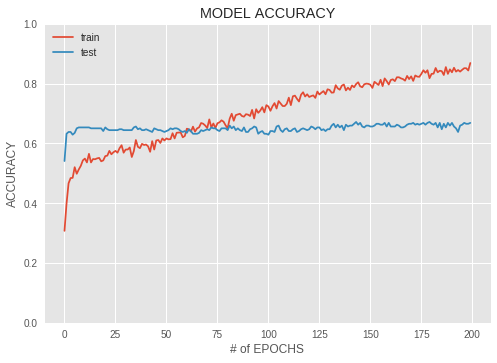

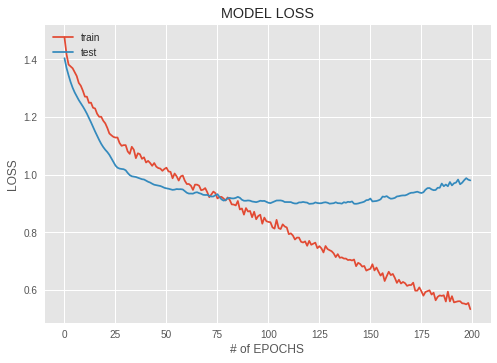

In [0]:
plot_modelacc(model_final)
plot_model_loss(model_final)

In [0]:
loss,acc = model_glove.evaluate(x_val,y_val, verbose = 2, batch_size = batch_size)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

Validation Loss: 0.98
Validation Accuracy: 0.67


**MODEL PERFORMANCE WITH RESPECT TO TEST DATA: CONFUSION MATRIX**

[[  3  12   8]
 [ 10  85  35]
 [  6  47 123]]


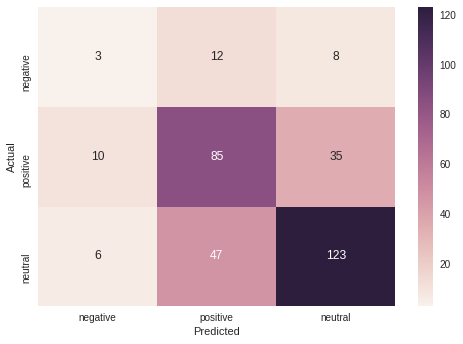

In [0]:
# Predicting the Test set results
y_pred = model_glove.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix 
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive','neutral']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")